The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [3]:
# set up display area to show dataframe in jupyter qtconsole
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Columns

Unavailable or self-documenting column names are marked with an "NA".

    MachineIdentifier - Individual machine ID
    ProductName - Defender state information e.g. win8defender
    EngineVersion - Defender state information e.g. 1.1.12603.0
    AppVersion - Defender state information e.g. 4.9.10586.0
    AvSigVersion - Defender state information e.g. 1.217.1014.0
    IsBeta - Defender state information e.g. false
    RtpStateBitfield - NA
    IsSxsPassiveMode - NA
    DefaultBrowsersIdentifier - ID for the machine's default browser
    AVProductStatesIdentifier - ID for the specific configuration of a user's antivirus software
    AVProductsInstalled - NA
    AVProductsEnabled - NA
    HasTpm - True if machine has tpm
    CountryIdentifier - ID for the country the machine is located in
    CityIdentifier - ID for the city the machine is located in
    OrganizationIdentifier - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
    GeoNameIdentifier - ID for the geographic region a machine is located in
    LocaleEnglishNameIdentifier - English name of Locale ID of the current user
    Platform - Calculates platform name (of OS related properties and processor property)
    Processor - This is the process architecture of the installed operating system
    OsVer - Version of the current operating system
    OsBuild - Build of the current operating system
    OsSuite - Product suite mask for the current operating system.
    OsPlatformSubRelease - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
    OsBuildLab - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
    SkuEdition - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.
    IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
    AutoSampleOptIn - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9+
    PuaMode - Pua Enabled mode from the service
    SMode - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
    IeVerIdentifier - NA
    SmartScreen - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.
    Firewall - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
    UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.
    Census_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible...)
    Census_DeviceFamily - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
    Census_OEMNameIdentifier - NA
    Census_OEMModelIdentifier - NA
    Census_ProcessorCoreCount - Number of logical cores in the processor
    Census_ProcessorManufacturerIdentifier - NA
    Census_ProcessorModelIdentifier - NA
    Census_ProcessorClass - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
    Census_PrimaryDiskTotalCapacity - Amount of disk space on primary disk of the machine in MB
    Census_PrimaryDiskTypeName - Friendly name of Primary Disk Type - HDD or SSD
    Census_SystemVolumeTotalCapacity - The size of the partition that the System volume is installed on in MB
    Census_HasOpticalDiskDrive - True indicates that the machine has an optical disk drive (CD/DVD)
    Census_TotalPhysicalRAM - Retrieves the physical RAM in MB
    Census_ChassisTypeName - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
    Census_InternalPrimaryDiagonalDisplaySizeInInches - Retrieves the physical diagonal length in inches of the primary display
    Census_InternalPrimaryDisplayResolutionHorizontal - Retrieves the number of pixels in the horizontal direction of the internal display.
    Census_InternalPrimaryDisplayResolutionVertical - Retrieves the number of pixels in the vertical direction of the internal display
    Census_PowerPlatformRoleName - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
    Census_InternalBatteryType - NA
    Census_InternalBatteryNumberOfCharges - NA
    Census_OSVersion - Numeric OS version Example - 10.0.10130.0
    Census_OSArchitecture - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
    Census_OSBranch - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fbl_partner_eeap where OsVersion = 6.4.9813.0.amd64fre.fbl_partner_eeap.140810-0005
    Census_OSBuildNumber - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
    Census_OSBuildRevision - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
    Census_OSEdition - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
    Census_OSSkuName - OS edition friendly name (currently Windows only)
    Census_OSInstallTypeName - Friendly description of what install was used on the machine i.e. clean
    Census_OSInstallLanguageIdentifier - NA
    Census_OSUILocaleIdentifier - NA
    Census_OSWUAutoUpdateOptionsName - Friendly name of the WindowsUpdate auto-update settings on the machine.
    Census_IsPortableOperatingSystem - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
    Census_GenuineStateName - Friendly name of OSGenuineStateID. 0 = Genuine
    Census_ActivationChannel - Retail license key or Volume license key for a machine.
    Census_IsFlightingInternal - NA
    Census_IsFlightsDisabled - Indicates if the machine is participating in flighting.
    Census_FlightRing - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
    Census_ThresholdOptIn - NA
    Census_FirmwareManufacturerIdentifier - NA
    Census_FirmwareVersionIdentifier - NA
    Census_IsSecureBootEnabled - Indicates if Secure Boot mode is enabled.
    Census_IsWIMBootEnabled - NA
    Census_IsVirtualDevice - Identifies a Virtual Machine (machine learning model)
    Census_IsTouchEnabled - Is this a touch device ?
    Census_IsPenCapable - Is the device capable of pen input ?
    Census_IsAlwaysOnAlwaysConnectedCapable - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .
    Wdft_IsGamer - Indicates whether the device is a gamer device or not based on its hardware combination.
    Wdft_RegionIdentifier - NA


In [4]:
# We need to explicitly specify data types when reading csv, otherwise it is very memory consuming
# and we will get the warning "Specify dtype option on import or set low_memory=False"
# So, we will manually defined the data types

# P.S. I have loaded the sample data and exported train_data.dtypes
# these are the data types for fast loading

datatypes = {'ProductName': str, 'EngineVersion': str, 'AppVersion': str, 'AvSigVersion': str, 'IsBeta': np.int64,
    'RtpStateBitfield': np.float64, 'IsSxsPassiveMode': np.int64, 'DefaultBrowsersIdentifier': np.float64,
    'AVProductStatesIdentifier': np.float64, 'AVProductsInstalled': np.float64, 'AVProductsEnabled': np.float64,
    'HasTpm': np.int64, 'CountryIdentifier': np.int64, 'CityIdentifier': np.float64, 'OrganizationIdentifier': np.float64,
    'GeoNameIdentifier': np.float64, 'LocaleEnglishNameIdentifier': np.int64, 'Platform': str, 'Processor': str,
    'OsVer': str, 'OsBuild': np.int64, 'OsSuite': np.int64, 'OsPlatformSubRelease': str, 'OsBuildLab': str,
    'SkuEdition': str, 'IsProtected': np.float64, 'AutoSampleOptIn': np.int64, 'PuaMode': str, 'SMode': np.float64,
    'IeVerIdentifier': np.float64, 'SmartScreen': str, 'Firewall': np.float64, 'UacLuaenable': np.float64,
    'Census_MDC2FormFactor': str, 'Census_DeviceFamily': str, 'Census_OEMNameIdentifier': np.float64,
    'Census_OEMModelIdentifier': np.float64, 'Census_ProcessorCoreCount': np.float64, 
    'Census_ProcessorManufacturerIdentifier': np.float64, 'Census_ProcessorModelIdentifier': np.float64,
    'Census_ProcessorClass': str, 'Census_PrimaryDiskTotalCapacity': np.float64, 
    'Census_PrimaryDiskTypeName': str, 'Census_SystemVolumeTotalCapacity': np.float64,
    'Census_HasOpticalDiskDrive': np.int64, 'Census_TotalPhysicalRAM': np.float64, 'Census_ChassisTypeName': str,
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': np.float64, 
    'Census_InternalPrimaryDisplayResolutionHorizontal': np.float64, 
    'Census_InternalPrimaryDisplayResolutionVertical': np.float64, 'Census_PowerPlatformRoleName': str,
    'Census_InternalBatteryType': str, 'Census_InternalBatteryNumberOfCharges': np.float64, 
    'Census_OSVersion': str, 'Census_OSArchitecture': str, 'Census_OSBranch': str, 'Census_OSBuildNumber': np.int64,
    'Census_OSBuildRevision': np.int64, 'Census_OSEdition': str, 'Census_OSSkuName': str, 
    'Census_OSInstallTypeName': str, 'Census_OSInstallLanguageIdentifier': np.float64, 
    'Census_OSUILocaleIdentifier': np.int64, 'Census_OSWUAutoUpdateOptionsName': str, 
    'Census_IsPortableOperatingSystem': np.int64, 'Census_GenuineStateName': str, 'Census_ActivationChannel': str,
    'Census_IsFlightingInternal': np.float64, 'Census_IsFlightsDisabled': np.float64, 'Census_FlightRing': str,
    'Census_ThresholdOptIn': np.float64, 'Census_FirmwareManufacturerIdentifier': np.float64, 
    'Census_FirmwareVersionIdentifier': np.float64, 'Census_IsSecureBootEnabled': np.int64, 
    'Census_IsWIMBootEnabled': np.float64, 'Census_IsVirtualDevice': np.float64, 'Census_IsTouchEnabled': np.int64,
    'Census_IsPenCapable': np.int64, 'Census_IsAlwaysOnAlwaysConnectedCapable': np.float64, 'Wdft_IsGamer': np.float64,
    'Wdft_RegionIdentifier': np.float64, 
    'HasDetections': np.int64}

#full_features = pd.read_csv("./csv/train.csv", index_col="MachineIdentifier", dtype=datatypes, nrows=10000)
full_features = pd.read_csv("./csv/train.csv", dtype=datatypes, nrows=10000)

In [5]:
print (full_features.shape)

(10000, 83)


In [6]:
# Let's see some details of the loaded data
full_features.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,10000.0,9966.000000,10000.000000,472.000000,9970.000000,9970.000000,9970.000000,10000.000000,10000.000000,9617.000000,6972.000000,10000.000000,10000.000000,10000.000000,10000.000000,9970.000000,10000.0,9391.000000,9925.000000,9904.000000,9991.000000,9896.000000,9885.000000,9956.000000,9956.000000,9956.000000,9.944000e+03,9.944000e+03,10000.000000,9908.00000,9950.000000,9950.000000,9950.000000,9.685000e+03,10000.000000,10000.000000,9927.000000,10000.000000,10000.00000,1691.0,9814.0,3628.0,9794.000000,9815.000000,10000.000000,3639.0,9983.000000,10000.000000,10000.0000,9922.000000,9691.000000,9691.000000,10000.000
mean,0.0,6.842364,0.017800,1585.576271,47816.197894,1.316951,1.019157,0.988900,109.487500,81116.637205,24.856713,172.288100,122.991800,15745.965000,569.494400,0.950953,0.0,0.000426,126.280302,0.977080,0.993594,2226.648848,238885.110774,4.019486,4.529329,2373.448373,5.108577e+05,3.760734e+05,0.071600,6204.30975,16.777940,1550.934472,899.647337,1.151681e+09,15844.879700,959.764800,14.705752,60.823900,0.00110,0.0,0.0,0.0,397.572289,32870.960978,0.481600,0.0,0.007613,0.119100,0.0358,0.056541,0.282221,7.863482,0.505
std,0.0,1.034253,0.132231,963.624211,14070.304518,0.516013,0.163146,0.104775,62.980792,49074.620573,5.691841,88.388531,69.338331,2170.463148,249.488175,0.215977,0.0,0.020635,41.626381,0.149656,0.079783,1321.792227,72906.422178,2.012123,1.292424,841.813896,3.511762e+05,3.215659e+05,0.257837,4659.15594,5.968945,371.549174,214.254172,1.902744e+09,1964.197178,2893.352406,10.246496,45.079795,0.03315,0.0,0.0,0.0,220.951175,21156.297631,0.499686,0.0,0.086924,0.323922,0.1858,0.230975,0.450103,4.594118,0.500
min,0.0,0.000000,0.000000,10.000000,39.000000,1.000000,0.000000,0.000000,1.000000,41.000000,1.000000,1.000000,2.000000,7601.000000,16.000000,0.000000,0.0,0.000000,41.000000,0.000000,0.000000,74.000000,150.000000,1.000000,1.000000,19.000000,1.068000e+04,1.012900e+04,0.000000,1023.00000,4.900000,640.000000,480.000000,0.000000e+00,10240.000000,0.000000,1.000000,5.000000,0.00000,0.0,0.0,0.0,93.000000,727.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,1.000000,0.000
25%,0.0,7.000000,0.000000,788.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36360.000000,18.000000,89.000000,74.000000,15063.000000,256.000000,1.000000,0.0,0.000000,111.000000,1.000000,1.000000,1443.000000,189816.000000,2.000000,5.000000,1998.000000,2.393720e+05,1.206715e+05,0.000000,4096.00000,13.900000,1366.000000,768.000000,0.000000e+00,15063.000000,165.000000,8.000000,31.000000,0.00000,0.0,0.0,0.0,142.000000,12950.500000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,3.000000,0.000
50%,0.0,7.000000,0.000000,1632.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,823

After taking a preliminary look at the data, we see that column 'AutoSampleOptIn' has only one value. Therefore is useless in calculations. Let's check the diversity of other columns

In [14]:
for col in full_features.columns:
    if len(full_features[col].unique()) == 1:
        print (col, len(full_features[col].unique()))

IsBeta 1
AutoSampleOptIn 1


As we see, there are two columns that we can disregard. These are 'IsBeta' and 'AutoSampleOptIn'

In [21]:
for col in full_features.columns:
    if len(full_features[col].unique()) == len(full_features):
        print (col, len(full_features[col].unique()))

MachineIdentifier 10000


The only column with completely unique values is 'MachineIdentifier'. Therefore, it is not useful too. And by logic, it is just the unique identifier of the machine, therefore has no influence on the attack prediction

In [22]:
print((full_features.isnull().sum()).sort_values(ascending=False).head(20))

PuaMode                                  9997
Census_ProcessorClass                    9958
DefaultBrowsersIdentifier                9528
Census_IsFlightingInternal               8309
Census_InternalBatteryType               7120
Census_ThresholdOptIn                    6372
Census_IsWIMBootEnabled                  6361
SmartScreen                              3604
OrganizationIdentifier                   3028
SMode                                     609
CityIdentifier                            383
Census_InternalBatteryNumberOfCharges     315
Wdft_RegionIdentifier                     309
Wdft_IsGamer                              309
Census_FirmwareManufacturerIdentifier     206
Census_IsFlightsDisabled                  186
Census_FirmwareVersionIdentifier          185
Census_OEMModelIdentifier                 115
Census_OEMNameIdentifier                  104
Firewall                                   96
dtype: int64


In [23]:
# As we see, 'IsBeta', 'AutoSampleOptIn', 'PuaMode' and 'Census_ProcessorClass' are the columns that are almost useless.
# I think we can drop them.
# 'MachineIdentifier' is the unique identifier of the machine. We can simply disregard it

full_features = full_features.drop(['PuaMode','Census_ProcessorClass','MachineIdentifier','IsBeta','AutoSampleOptIn'], axis=1)

In [24]:
# As seen i data analysis above, there are also many NaN values in the dataset
# Let's replace them either by -1 it the data type is numeric or by 'N/A' if
# the data type is string

nanvalues = {
    'ProductName': 'N/A', 'EngineVersion': 'N/A', 'AppVersion': 'N/A', 'AvSigVersion': 'N/A',
    'RtpStateBitfield': -1., 'IsSxsPassiveMode': -1, 'DefaultBrowsersIdentifier': -1.,
    'AVProductStatesIdentifier': -1., 'AVProductsInstalled': -1., 'AVProductsEnabled': -1.,
    'HasTpm': -1, 'CountryIdentifier': -1, 'CityIdentifier': -1., 'OrganizationIdentifier': -1.,
    'GeoNameIdentifier': -1, 'LocaleEnglishNameIdentifier': -1, 'Platform': 'N/A', 'Processor': 'N/A',
    'OsVer': 'N/A', 'OsBuild': -1, 'OsSuite': -1, 'OsPlatformSubRelease': 'N/A', 'OsBuildLab': 'N/A',
    'SkuEdition': 'N/A', 'IsProtected': -1., 'SMode': -1.,
    'IeVerIdentifier': -1., 'SmartScreen': 'N/A', 'Firewall': -1., 'UacLuaenable': -1.,
    'Census_MDC2FormFactor': 'N/A', 'Census_DeviceFamily': 'N/A', 'Census_OEMNameIdentifier': -1.,
    'Census_OEMModelIdentifier': -1., 'Census_ProcessorCoreCount': -1., 
    'Census_ProcessorManufacturerIdentifier': -1., 'Census_ProcessorModelIdentifier': -1.,
    'Census_PrimaryDiskTotalCapacity': -1., 
    'Census_PrimaryDiskTypeName': 'N/A', 'Census_SystemVolumeTotalCapacity': -1.,
    'Census_HasOpticalDiskDrive': -1, 'Census_TotalPhysicalRAM': -1., 'Census_ChassisTypeName': 'N/A',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': -1., 
    'Census_InternalPrimaryDisplayResolutionHorizontal': -1., 
    'Census_InternalPrimaryDisplayResolutionVertical': -1., 'Census_PowerPlatformRoleName': 'N/A',
    'Census_InternalBatteryType': 'N/A', 'Census_InternalBatteryNumberOfCharges': -1., 
    'Census_OSVersion': 'N/A', 'Census_OSArchitecture': 'N/A', 'Census_OSBranch': 'N/A', 'Census_OSBuildNumber': -1,
    'Census_OSBuildRevision': -1, 'Census_OSEdition': 'N/A', 'Census_OSSkuName': 'N/A', 
    'Census_OSInstallTypeName': 'N/A', 'Census_OSInstallLanguageIdentifier': -1., 
    'Census_OSUILocaleIdentifier': -1, 'Census_OSWUAutoUpdateOptionsName': 'N/A', 
    'Census_IsPortableOperatingSystem': -1, 'Census_GenuineStateName': 'N/A', 'Census_ActivationChannel': 'N/A',
    'Census_IsFlightingInternal': -1., 'Census_IsFlightsDisabled': -1., 'Census_FlightRing': 'N/A',
    'Census_ThresholdOptIn': -1., 'Census_FirmwareManufacturerIdentifier': -1., 
    'Census_FirmwareVersionIdentifier': -1., 'Census_IsSecureBootEnabled': -1, 
    'Census_IsWIMBootEnabled': -1., 'Census_IsVirtualDevice': -1., 'Census_IsTouchEnabled': -1,
    'Census_IsPenCapable': -1, 'Census_IsAlwaysOnAlwaysConnectedCapable': -1., 'Wdft_IsGamer': -1.,
    'Wdft_RegionIdentifier': -1.
}

full_features = full_features.fillna(value=nanvalues)

In [25]:
full_features

,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7.0,0,-1.0,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,137.0,N/A,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2341.0,476940.0,HDD,299451.0,0,4096.0,Desktop,18.9,1440.0,900.0,Desktop,N/A,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,-1.0,0.0,Retail,-1.0,628.0,36144.0,0,-1.0,0.0,0,0,0.0,0.0,10.0,0
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,7.0,0,-1.0,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,137.0,N/A,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,2405.0,476940.0,HDD,102385.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,N/A,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,-1.0,0.0,NOT_SET,-1.0,628.0,57858.0,0,-1.0,0.0,0,0,0.0,0.0,8.0,0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7.0,0,-1.0,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4909.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,0,4096.0,Desktop,21.5,1920.0,1080.0,Desktop,N/A,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,-1.0,0.0,Retail,-1.0,142.0,52682.0,0,-1.0,0.0,0,0,0.0,0.0,3.0,0
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7.0,0,-1.0,53447.0,1.0,1.0,1,88,20710.0,-1.0,117.0,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,2273.0,238475.0,UNKNOWN,227116.0,0,4096.0,MiniTower,18.5,1366.0,768.0,Desktop,N/A,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,-1.0,0.0,Retail,-1.0,355.0,20050.0,0,-1.0,0.0,0,0,0.0,0.0,3.0,1
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7.0,0,-1.0,53447.0,1.0,1.0,1,18,37376.0,-1.0,277.0,75,window

In [31]:
full_labels = full_features["HasDetections"]

# Shuffle the data
np.random.seed(0)
shuffle = np.random.permutation(np.arange(full_features.shape[0]))

train_features, test_features, train_labels, test_labels = \
    train_test_split(full_features.values[shuffle], full_labels.values[shuffle], train_size=0.90)

print (train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

(9000, 78) (1000, 78) (9000,) (1000,)


In [32]:
enc = OrdinalEncoder()
train_features_encoded = enc.fit_transform(train_features)

print(train_features_encoded.shape)

(9000, 78)


In [33]:
train_features_encoded

array([[ 1., 29., 28., ...,  1., 11.,  1.],
       [ 1., 29., 13., ...,  1., 11.,  0.],
       [ 1., 28.,  9., ...,  1.,  1.,  0.],
       ...,
       [ 1., 28., 48., ...,  1., 11.,  1.],
       [ 1., 29., 28., ...,  0.,  0.,  0.],
       [ 1., 28., 28., ...,  2.,  1.,  1.]])

In [36]:
model = PCA(n_components=20)
model.fit_transform(train_features_encoded)

# We need cumulative sums by components
variances = model.explained_variance_ratio_.cumsum()

for k in range(len(variances)):
    print ("k =", k + 1, " Variance =", variances[k])

k = 1  Variance = 0.528554799162275
k = 2  Variance = 0.6887402324798074
k = 3  Variance = 0.8391773919517092
k = 4  Variance = 0.9646591324468111
k = 5  Variance = 0.9833166635077167
k = 6  Variance = 0.9898816681212
k = 7  Variance = 0.995853719173187
k = 8  Variance = 0.9973864639033708
k = 9  Variance = 0.9981283760878069
k = 10  Variance = 0.9987447349732672
k = 11  Variance = 0.9992142413885295
k = 12  Variance = 0.9994022312791501
k = 13  Variance = 0.999558299062054
k = 14  Variance = 0.9996529628309513
k = 15  Variance = 0.9997437612617274
k = 16  Variance = 0.9998142127116678
k = 17  Variance = 0.9998809862354283
k = 18  Variance = 0.9999128163171729
k = 19  Variance = 0.9999356713038036
k = 20  Variance = 0.9999506531430982


(9000, 2) (9000,)


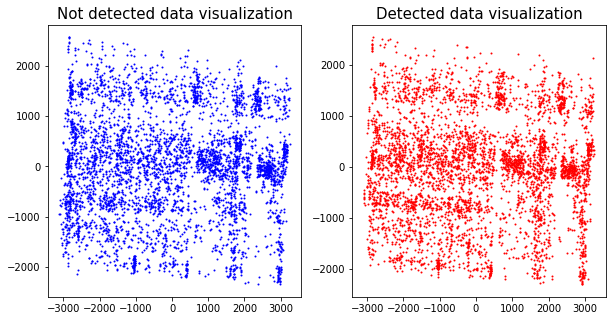

In [41]:
model = PCA(n_components=2)
pca_results = np.array(model.fit_transform(train_features_encoded))

print (pca_results.shape, train_labels.shape)

# when train_label == 1, then malware was detected
# when train_label == 0, malware was NOT detected

plt.figure(figsize=(10,5))
for i in range(2):
    color = 'bo' if i == 0 else 'ro'
    title = "Not detected data visualization" if i == 0 else "Detected data visualization"
    plt.subplot(1, 2, i + 1)
    plt.plot(pca_results[:,0][train_labels==i], pca_results[:,1][train_labels==i], color, markersize=1)
    plt.title(title, fontsize = 15)


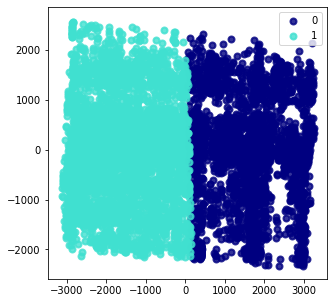

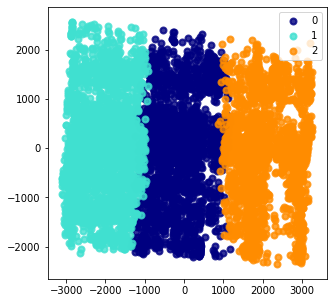

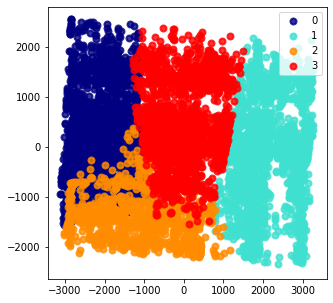

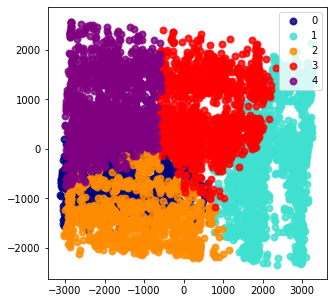

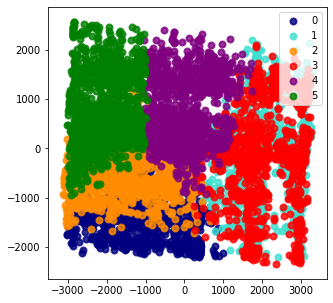

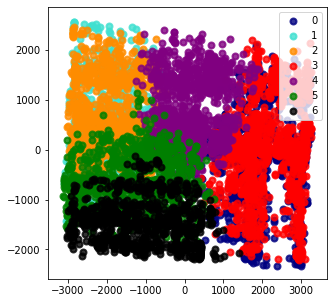

In [67]:
# Apply k-means + PCA + plot

from sklearn.cluster import KMeans

colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'black']

for k in range(2,8):
    # Fit the training data to a k-means clustering estimator model
    kmeans = KMeans(n_clusters=k).fit(train_features_encoded)

    # Retrieve the labels assigned to each training sample
    kmeans_y = kmeans.labels_
    
    plt.figure(figsize=(5,5))
    for color, cat in zip(colors, range(k)):
        plt.scatter(pca_results[kmeans_y==cat, 0],
                pca_results[kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.show()